# Experiments in Modeling Token Frequency in Texts as Wave Signals

## Load Libraries and Utility Functions

In [2]:
import os
import re
import pandas as pd
from tqdm import tqdm
import altair as alt
alt.data_transformers.disable_max_rows()
from collections import deque
import warnings
warnings.filterwarnings('ignore')
from rich.console import Console
from rich.table import Table
import numpy as np
from scipy.fft import fft
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import pywt
import matplotlib.pyplot as plt
console = Console()
import sys

sys.path.append("..")
from segmentation_scripts.utils import read_csv_file, get_data_directory_path, generate_table
from segmentation_scripts.generate_frequency_analysis import process_tokens

In [3]:
data_directory_path = get_data_directory_path()
preidentified_periodicals_df = read_csv_file(os.path.join(data_directory_path, "HathiTrust-pcc-datasets", "datasets", "periodical_metadata", "classified_preidentified_periodicals_with_full_metadata.csv"))

In [4]:
matching_files = []
for directory, _, files in tqdm(os.walk("../datasets/annotated_ht_ef_datasets/"), desc="Counting matching files"):
	for file in files:
		if file.endswith(".csv") and 'individual' in file:
			if os.path.exists(os.path.join(directory, file)):
				publication_name = directory.split("/")[-2]
				volume_number = directory.split("/")[-1]
				matching_files.append({"file": file, "directory": directory, "file_path": os.path.join(directory, file), "periodical_title": publication_name, "volume_directory": volume_number})
matching_files_df = pd.DataFrame(matching_files)
console.print(f"Found {len(matching_files_df)} matching files.", style="bright_green")

Counting matching files: 95it [00:00, 22020.39it/s]


Found 85 matching files.

In [5]:
# file_path = matching_files_df[matching_files_df.volume_directory.str.contains("053")]['file_path'].values[0]
# data_directory_path = get_data_directory_path()
# publication_directory = "ht_ef_datasets/eritrea_information"
# volume_directory = "inu_30000125593339"
# file_path = os.path.join(data_directory_path, "HathiTrust-pcc-datasets", "datasets", publication_directory, "volumes", volume_directory, volume_directory + "_individual_tokens.csv")
file_path = matching_files_df[matching_files_df.periodical_title.str.contains("observer")].file_path.values[0]
preidentified_periodical = True

### Explore PYWT Built-in Wavelet Families


In [6]:
for family in pywt.families():
	console.print("%s family: " % family + ', '.join(pywt.wavelist(family)), style="bright_cyan")
console.print(f" pywt.Modes.modes: {pywt.Modes.modes}", style="bright_magenta")

haar family: haar

db family: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19,
db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38

sym family: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17,
sym18, sym19, sym20

coif family: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14,
coif15, coif16, coif17

bior family: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, 
bior3.9, bior4.4, bior5.5, bior6.8

rbio family: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, 
rbio3.9, rbio4.4, rbio5.5, rbio6.8

dmey family: dmey

gaus family: gaus1, gaus2, gaus3, gaus4, gaus5, gaus6, gaus7, gaus8

mexh family: mexh

morl family: morl

cgau family: cgau1, cgau2, cgau3, cgau4, cgau5, cgau6, cgau7, cgau8

shan family: shan

fbsp family: fbsp

cmor family: cmor

 pywt.Modes.modes: ['zero', 'constant', 'symmetric', 'periodic', 'smooth', 'periodization', 'reflect', 
'antisymmetric', 'antireflect']

## Analyze the Waveforms of the Volume Data

In [7]:
merged_df, grouped_df, tokens_standardized_signal, tokens_smoothed_signal = process_tokens(file_path, preidentified_periodical, False, False)

Volume has this many tokens: 270914

Volume has this many issues: 17

Volume has this many pages: 924

Expanded volume has this many tokens: 546194

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1964-09-07  │     1      │    55     │       55        │
│ 1964-09-14  │     56     │    108    │       53        │
│ 1964-09-21  │    109     │    163    │       55        │
│ 1964-09-28  │    164     │    218    │       55        │
│ 1964-10-05  │    219     │    273    │       55        │
│ 1964-10-12  │    274     │    329    │       56        │
│ 1964-10-19  │    330     │    385    │       56        │
│ 1964-10-26  │    386     │    438    │       53        │
│ 1964-11-02  │    439     │    491    │       53        │
│ 1964-11-09  │    492     │    544    │       53        │
│ 1964-11-16  │    545     │    598    │       54        │
│ 1964-11-23  │    599     │    653    │       55        │
│ 1964-11-30  │    654     │    708    │       55        │
│ 1964-12-07  │    709     │    761    │       53        │
│ 1964-12-14  │    762     │    814    │       53        │
│ 1964-12-21  │    815     │    868    │       54        │
│ 1964-12-28  │    869     │    924    │       56        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of digits in this volume: 5962

Number of non-digit pages in this volume: 128

Number of digits in this volume after filtering for max page length: 5962

Number of pages without digits in this volume after filtering for max page length: 0

Number of pages after including non-digit pages: 924

Calculating digits per page: 100%|██████████| 924/924 [00:00<00:00, 24678.82it/s]


      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1964-09-07  │ 0.013519305146433288 │
│ 1964-09-14  │ 0.017178890809582303 │
│ 1964-09-21  │ 0.015304609843624776 │
│ 1964-09-28  │ 0.012112141871318679 │
│ 1964-10-05  │ 0.013441608059380562 │
│ 1964-10-12  │ 0.01421688443069964  │
│ 1964-10-19  │ 0.03567280896582862  │
│ 1964-10-26  │ 0.011775124279504088 │
│ 1964-11-02  │ 0.01854439037113458  │
│ 1964-11-09  │ 0.018430630765583312 │
│ 1964-11-16  │ 0.01425762916368933  │
│ 1964-11-23  │ 0.01735422210731722  │
│ 1964-11-30  │ 0.015255320768320526 │
│ 1964-12-07  │ 0.013865227631400337 │
│ 1964-12-14  │ 0.013443828682828639 │
│ 1964-12-21  │ 0.01360052466960419  │
│ 1964-12-28  │ 0.013452005184268891 │
└─────────────┴──────────────────────┘

 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1964-10-12  │  462  │
│ 1964-11-09  │  457  │
│ 1964-11-16  │  395  │
│ 1964-09-14  │  376  │
│ 1964-10-19  │  375  │
│ 1964-11-23  │  373  │
│ 1964-12-21  │  372  │
│ 1964-09-21  │  372  │
│ 1964-10-05  │  365  │
│ 1964-12-28  │  357  │
│ 1964-12-14  │  357  │
│ 1964-09-28  │  328  │
│ 1964-10-26  │  323  │
│ 1964-12-07  │  313  │
│ 1964-11-30  │  312  │
│ 1964-11-02  │  296  │
│ 1964-09-07  │  257  │
└─────────────┴───────┘

                                               Token and Digit Data                                                
┏━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Pag… ┃ Tokens… ┃ Smoothed tokens … ┃ Standardized tokens… ┃ Digits … ┃ Smoothed digits… ┃ Standardized digits … ┃
┡━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1.0  │  22.0   │        0.0        │ -2.1673690971545136  │   4.0    │       0.0        │  -0.9524829822740314  │
│ 2.0  │  68.0   │        0.0        │ -2.1673690971545136  │   0.0    │       0.0        │  -0.9524829822740314  │
└──────┴─────────┴───────────────────┴──────────────────────┴──────────┴──────────────────┴───────────────────────┘

Likely issue length from tokens autocorrelation: 1

Dominant Frequency: 0.0367965367965368

Number of pages marked as likely covers: 206

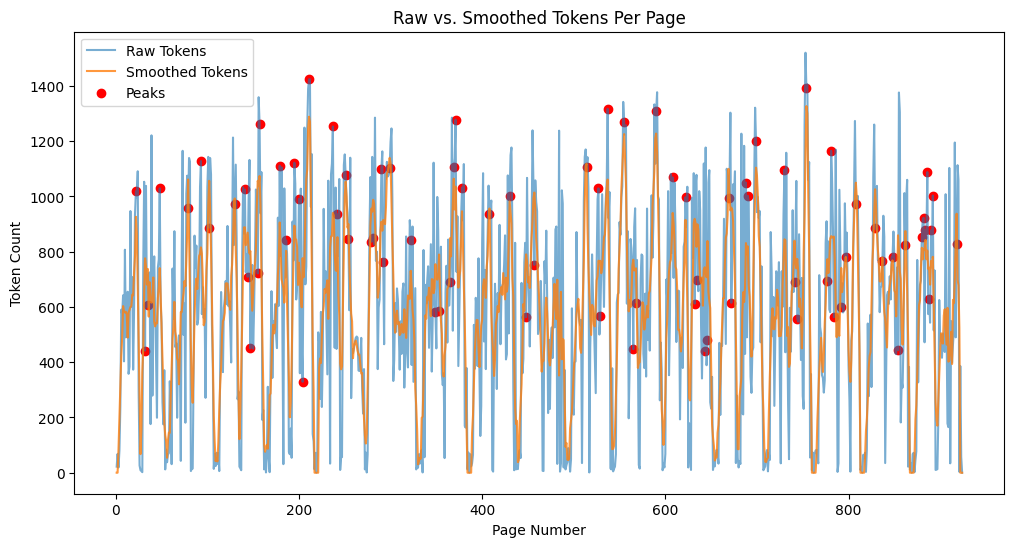

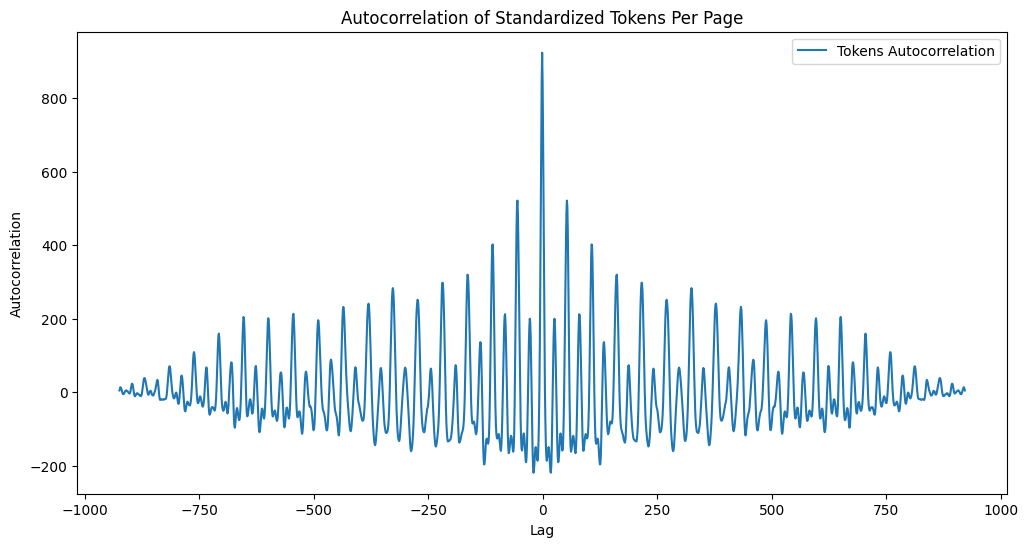

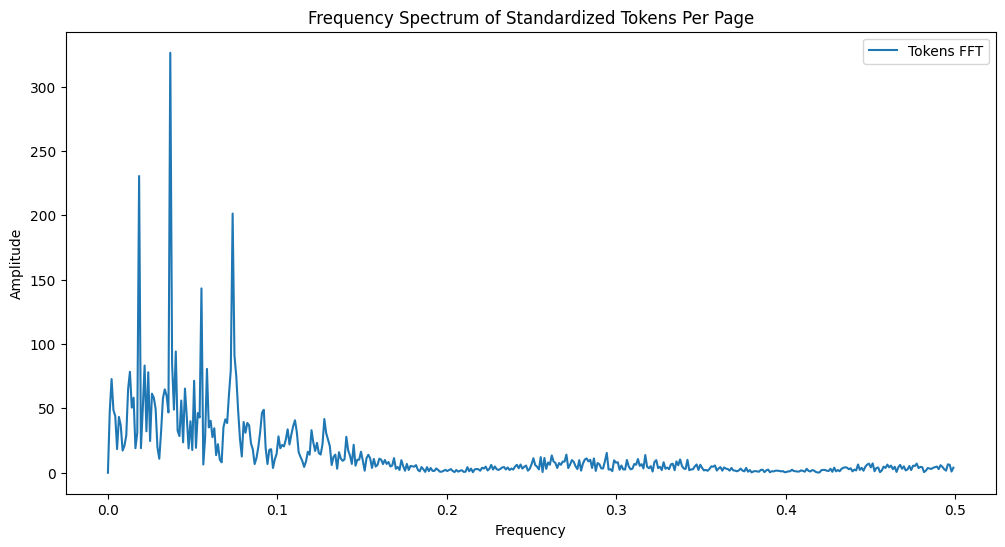

Volume Features:
{
    'avg_tokens': 591.1190476190476,
    'dominant_frequency': 0.0367965367965368,
    'issue_length': 1,
    'htid': 'mdp.39015056038220',
    'periodical_name': 'Arab Observer and The Scribe'
}

In [8]:

# --- Autocorrelation Analysis for Issue Length ---
tokens_autocorr = np.correlate(merged_df['standardized_tokens_per_page'].values, 
                               merged_df['standardized_tokens_per_page'].values, mode='full')

# Find dominant lag (likely issue length)
tokens_autocorr_lag = np.argmax(tokens_autocorr[len(tokens_autocorr) // 2 + 1:]) + 1
console.print(f"Likely issue length from tokens autocorrelation: {tokens_autocorr_lag}", style="bright_green")

# --- Peak Detection (Standardized Tokens) ---
token_peaks, _ = find_peaks(merged_df['standardized_tokens_per_page'], height=0.5)
merged_df['is_token_peak'] = 0
merged_df.loc[token_peaks, 'is_token_peak'] = 1

# --- FFT for Frequency Analysis ---
tokens_fft_input = merged_df['standardized_tokens_per_page'].values - np.mean(merged_df['standardized_tokens_per_page'].values)
tokens_fft = fft(tokens_fft_input)
frequencies = np.fft.fftfreq(len(tokens_fft))

dominant_frequency_index = np.argmax(np.abs(tokens_fft[1:len(frequencies)//2])) + 1
dominant_frequency = abs(frequencies[dominant_frequency_index])
console.print(f"Dominant Frequency: {dominant_frequency}", style="bright_green")

# Detect likely covers based on low standardized tokens and digits
merged_df['is_likely_cover'] = (
    (merged_df['standardized_tokens_per_page'] < -0.5) &  # Threshold for low token counts
    (merged_df['standardized_digits_per_page'] < -0.5)    # Threshold for low digit counts
)

# Summary of likely covers
num_covers = merged_df['is_likely_cover'].sum()
console.print(f"Number of pages marked as likely covers: {num_covers}", style="bright_green")

# --- Visualization ---
# Raw vs Smoothed Tokens
plt.figure(figsize=(12, 6))
plt.plot(merged_df['page_number'], merged_df['tokens_per_page'], label='Raw Tokens', alpha=0.6)
plt.plot(merged_df['page_number'], merged_df['smoothed_tokens_per_page'], label='Smoothed Tokens', alpha=0.8)
plt.scatter(merged_df['page_number'].iloc[token_peaks], merged_df['tokens_per_page'].iloc[token_peaks], color='red', label='Peaks')
plt.title("Raw vs. Smoothed Tokens Per Page")
plt.xlabel("Page Number")
plt.ylabel("Token Count")
plt.legend()
plt.show()

# Autocorrelation Plot
lags = np.arange(-len(tokens_autocorr) // 2, len(tokens_autocorr) // 2)
plt.figure(figsize=(12, 6))
plt.plot(lags, tokens_autocorr, label='Tokens Autocorrelation')
plt.title("Autocorrelation of Standardized Tokens Per Page")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

# Frequency Analysis Plot
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(tokens_fft[:len(frequencies)//2]), label='Tokens FFT')
plt.title("Frequency Spectrum of Standardized Tokens Per Page")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# --- Aggregated Features ---
volume_features = {
    'avg_tokens': merged_df['tokens_per_page'].mean(),
    'dominant_frequency': dominant_frequency,
    'issue_length': tokens_autocorr_lag,
    'htid': merged_df['htid'].unique()[0],
    'periodical_name': merged_df['periodical_name'].unique()[0]
}

console.print("Volume Features:", volume_features)

In [9]:
def energy_entropy_ratio(coeffs):
	"""
	Compute energy-to-entropy ratio for wavelet coefficients.

	Parameters:
	-----------
	coeffs : np.ndarray
		Wavelet coefficients (can be complex).

	Returns:
	--------
	ratio : float
		Energy-to-entropy ratio.
	"""
	# Use absolute values of coefficients for energy and entropy computation
	magnitudes = np.abs(coeffs)
	total_energy = np.sum(magnitudes ** 2)
	entropy = -np.sum(
		(magnitudes ** 2 / total_energy) * np.log2(magnitudes ** 2 / total_energy + 1e-12)
	)  # Add a small constant to avoid log(0)
	return total_energy / (entropy if entropy > 0 else 1e-12)  # Avoid division by zero


def sparsity_measure(coeffs, threshold=1e-3):
	"""
	Measure sparsity of wavelet coefficients.

	Parameters:
	-----------
	coeffs : np.ndarray
		Wavelet coefficients (can be complex).

	Returns:
	--------
	sparsity : float
		Percentage of near-zero coefficients.
	"""
	# Use absolute values of coefficients for sparsity computation
	total_coeffs = np.abs(np.concatenate(coeffs))
	sparsity = np.sum(total_coeffs < threshold) / len(total_coeffs)
	return sparsity


# Evaluate Wavelet Performance (DWT)
def evaluate_dwt_performance(signal, wavelets, modes, signal_type):
	results = []
	skipped_wavelets = []
	for wavelet in tqdm(wavelets, desc=f"Testing DWT Wavelets for {signal_type}"):
		try:
			wavelet_filter_len = pywt.Wavelet(wavelet).dec_len
			if len(signal) < wavelet_filter_len:
				raise ValueError(f"Signal is too short for wavelet {wavelet}")

			max_level = pywt.dwt_max_level(len(signal), filter_len=wavelet_filter_len)
			for level in range(1, max_level + 1):
				for mode in modes:
					try:
						# Decompose signal
						coeffs = pywt.wavedec(signal, wavelet, level=level, mode=mode)
						# Check if all coefficient lengths are consistent
						coeff_shapes = [len(c) for c in coeffs]
						if len(set(coeff_shapes)) > 1:
							skipped_wavelets.append({'wavelet': wavelet, 'level': level, 'mode': mode, 'coeff_shapes': coeff_shapes})
							continue
						# Reconstruct signal
						reconstructed_signal = pywt.waverec(coeffs, wavelet, mode=mode)[:len(signal)]

						# Compute Metrics
						mse = np.mean((signal - reconstructed_signal) ** 2)
						energy_entropy = energy_entropy_ratio(coeffs)
						sparsity = sparsity_measure(coeffs)

						# Append Results
						results.append({
							'signal_type': signal_type,
							'wavelet': wavelet,
							'wavelet_level': level,
							'wavelet_mode': mode,
							'wavelet_mse': mse,
							'wavelet_energy_entropy': energy_entropy,
							'wavelet_sparsity': sparsity
						})
					except ValueError as e:
						print(f"Skipping wavelet {wavelet}, level {level}, mode {mode}: {e}")
		except Exception as e:
			print(f"Error testing wavelet {wavelet}: {e}")
	skipped_wavelets_df = pd.DataFrame(skipped_wavelets)
	console.print(f"Skipped wavelets: {len(skipped_wavelets_df)}", style="bright_red")
	total_results = pd.DataFrame(results)
	console.print(f"Total DWT results: {len(total_results)}", style="bright_green")
	return total_results, skipped_wavelets_df


# Evaluate Wavelet Performance (CWT)
def evaluate_cwt_performance(signal, wavelets, signal_type, scales):
	results = []

	for wavelet in tqdm(wavelets, desc=f"Testing CWT Wavelets for {signal_type}"):
		try:
			# Perform Continuous Wavelet Transform
			coeffs, frequencies = pywt.cwt(signal, scales=scales, wavelet=wavelet)
			# Compute Metrics
			total_energy = np.sum(coeffs ** 2)
			entropy = -np.sum(coeffs ** 2 / total_energy * np.log2(coeffs ** 2 / total_energy), axis=None)
			energy_entropy = total_energy / entropy if entropy > 0 else np.inf
			sparsity = np.sum(np.abs(coeffs) < 1e-3) / coeffs.size

			# Append Results
			results.append({
				'signal_type': signal_type,
				'wavelet': wavelet,
				'wavelet_energy_entropy': energy_entropy,
				'wavelet_sparsity': sparsity
			})
		except Exception as e:
			print(f"Error testing wavelet {wavelet}: {e}")
	total_results = pd.DataFrame(results)
	console.print(f"Total CWT results: {len(total_results)}", style="bright_green")
	return total_results


# Parameters
weights = {'wavelet_mse': 0.5, 'wavelet_energy_entropy': 0.3, 'wavelet_sparsity': 0.2}
dwt_wavelets = pywt.wavelist(kind='discrete')
cwt_wavelets = pywt.wavelist(kind='continuous')
modes = pywt.Modes.modes
scales = np.arange(1, 128)  # Adjustable range of scales for CWT

# Preprocess Signals
raw_signal = np.nan_to_num(merged_df['tokens_per_page'].values, nan=0.0, posinf=0.0, neginf=0.0)
smoothed_signal = np.nan_to_num(merged_df['smoothed_tokens_per_page'].values, nan=0.0, posinf=0.0, neginf=0.0)
console.print(f"Raw Signal Length: {len(raw_signal)}", style="bright_green")
console.print(f"Smoothed Signal Length: {len(smoothed_signal)}", style="bright_green")
# Select appropriate wavelet method based on signal type
if len(raw_signal) > 500:  # Example threshold for selecting CWT
	cwt_raw_results = evaluate_cwt_performance(raw_signal, cwt_wavelets, 'raw', scales=scales)
	cwt_smoothed_results = evaluate_cwt_performance(smoothed_signal, cwt_wavelets, 'smoothed', scales=scales)

dwt_raw_results, dwt_raw_skipped_results = evaluate_dwt_performance(raw_signal, dwt_wavelets, modes, 'raw')
dwt_smoothed_results, dwt_smoothed_skipped_results = evaluate_dwt_performance(smoothed_signal, dwt_wavelets, modes, 'smoothed')

Raw Signal Length: 924

Smoothed Signal Length: 924

Testing CWT Wavelets for raw: 100%|██████████| 21/21 [00:01<00:00, 20.50it/s]


Total CWT results: 21

Testing CWT Wavelets for smoothed: 100%|██████████| 21/21 [00:01<00:00, 20.90it/s]


Total CWT results: 21

Testing DWT Wavelets for raw: 100%|██████████| 106/106 [00:00<00:00, 916.62it/s]


Skipped wavelets: 3879

Total DWT results: 954

Testing DWT Wavelets for smoothed: 100%|██████████| 106/106 [00:00<00:00, 916.63it/s]


Skipped wavelets: 3879

Total DWT results: 954

In [10]:
def determine_best_representation(results_df, weights, is_combined=False):
    """
    Normalize and rank wavelet metrics for CWT and DWT results.

    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame containing wavelet metrics.
    weights : dict
        Weights for metrics (e.g., MSE, Energy-to-Entropy, and Sparsity).
    is_combined : bool, optional
        If True, prefixes column names with 'combined_'.

    Returns:
    --------
    tuple:
        - best_config : pd.DataFrame
          Best wavelet configuration.
        - ranked_results : pd.DataFrame
          Ranked results with normalized metrics.
    """
    # Convert complex metrics to magnitudes
    for column in ['wavelet_mse', 'wavelet_energy_entropy', 'wavelet_sparsity']:
        if column in results_df.columns:
            results_df[column] = np.abs(results_df[column])

    # Normalize metrics
    scaler = MinMaxScaler()
    normalized_df = results_df.copy()
    prefix = 'combined_' if is_combined else ''
    
    # Handle missing metrics for CWT (e.g., no MSE)
    metrics = ['wavelet_energy_entropy', 'wavelet_sparsity']
    if 'wavelet_mse' in results_df.columns:
        metrics.insert(0, 'wavelet_mse')  # Add MSE for DWT results

    # Normalize specified metrics
    normalized_metrics = [f"{prefix}{metric}_norm" for metric in metrics]
    normalized_df[normalized_metrics] = scaler.fit_transform(results_df[metrics])
    if 'wavelet_mse' in results_df.columns:
        normalized_df[f'{prefix}wavelet_mse_norm'] = 1 - normalized_df[f'{prefix}wavelet_mse_norm']  # Lower MSE is better

    # Compute combined scores
    normalized_df[f'{prefix}wavelet_norm_combined_score'] = sum(
        weights[metric] * normalized_df[f'{prefix}{metric}_norm'] 
        for metric in metrics
    )

    # Rank results
    ranked_results = normalized_df.sort_values(
        by=f'{prefix}wavelet_norm_combined_score', ascending=False
    ).reset_index(drop=True)
    ranked_results[f'{prefix}wavelet_rank'] = ranked_results.index + 1

    # Return the best configuration and ranked results
    best_config = ranked_results[0:1]
    return best_config, ranked_results

def compare_and_rank_wavelet_metrics(raw_signal, smoothed_signal, dwt_wavelets, cwt_wavelets, modes, weights, scales):
    """
    Compare wavelet metrics for raw and smoothed tokens across DWT and CWT.

    Parameters:
    -----------
    raw_signal : np.ndarray
        Raw tokens per page.
    smoothed_signal : np.ndarray
        Smoothed tokens per page.
    dwt_wavelets : list of str
        List of DWT wavelet names to test.
    cwt_wavelets : list of str
        List of CWT wavelet names to test.
    modes : list of str
        List of signal extension modes to test for DWT.
    weights : dict
        Weights for metrics (e.g., MSE, Energy-to-Entropy, and Sparsity).
    scales : np.ndarray
        Scales to use for CWT.

    Returns:
    --------
    pd.DataFrame
        Combined results across DWT and CWT.
    """
    # Evaluate metrics for DWT
    dwt_raw_results, dwt_raw_skipped_results = evaluate_dwt_performance(raw_signal, dwt_wavelets, modes, 'raw')
    dwt_smoothed_results, dwt_smoothed_skipped_results = evaluate_dwt_performance(smoothed_signal, dwt_wavelets, modes, 'smoothed')

    # Evaluate metrics for CWT
    cwt_raw_results = evaluate_cwt_performance(raw_signal, cwt_wavelets, 'raw', scales=scales)
    cwt_smoothed_results = evaluate_cwt_performance(smoothed_signal, cwt_wavelets, 'smoothed', scales=scales)

    # Combine results
    dwt_combined_results = pd.concat([dwt_raw_results, dwt_smoothed_results], ignore_index=True)
    cwt_combined_results = pd.concat([cwt_raw_results, cwt_smoothed_results], ignore_index=True)

    # Determine best representations
    best_dwt, ranked_dwt = determine_best_representation(dwt_combined_results, weights)
    best_cwt, ranked_cwt = determine_best_representation(cwt_combined_results, weights)

    # Combine DWT and CWT results
    combined_results = pd.concat([ranked_dwt, ranked_cwt], ignore_index=True)

    # Determine overall best representation
    best_combined_results, ranked_combined_results = determine_best_representation(
        combined_results, weights, is_combined=True
    )

    # Display results
    generate_table(best_dwt, "Best DWT Wavelet Configuration")
    generate_table(best_cwt, "Best CWT Wavelet Configuration")
    generate_table(best_combined_results, "Best Combined Wavelet Configuration")

    return ranked_combined_results, best_combined_results, ranked_dwt, ranked_cwt

# Compare and Rank Wavelet Metrics
ranked_combined_results, best_combined_results, ranked_dwt, ranked_cwt = compare_and_rank_wavelet_metrics(
	raw_signal, smoothed_signal, dwt_wavelets, cwt_wavelets, modes, weights, scales
)

Testing DWT Wavelets for raw: 100%|██████████| 106/106 [00:00<00:00, 631.15it/s]


Skipped wavelets: 3879

Total DWT results: 954

Testing DWT Wavelets for smoothed: 100%|██████████| 106/106 [00:00<00:00, 915.96it/s]


Skipped wavelets: 3879

Total DWT results: 954

Testing CWT Wavelets for raw: 100%|██████████| 21/21 [00:01<00:00, 20.17it/s]


Total CWT results: 21

Testing CWT Wavelets for smoothed: 100%|██████████| 21/21 [00:01<00:00, 19.94it/s]


Total CWT results: 21

                                          Best DWT Wavelet Configuration                                           
┏━━┳┳━━━━┳━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━┓
┃  ┃┃ W… ┃ … ┃ Wavelet m… ┃ Wavelet en… ┃ Wavel… ┃ Wave… ┃ Wavelet energy e… ┃ Wavelet s… ┃ Wavelet norm com… ┃ … ┃
┡━━╇╇━━━━╇━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━┩
│  ││ 1  │ … │ 9.0379263… │ 85339171.5… │ 0.025… │  1.0  │        1.0        │    0.5     │        0.9        │ 1 │
└──┴┴────┴───┴────────────┴─────────────┴────────┴───────┴───────────────────┴────────────┴───────────────────┴───┘

                                          Best CWT Wavelet Configuration                                           
┏━━━━━━┳━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Sig… ┃  ┃ Wavelet energ… ┃ Wavelet sparsi… ┃ Wavelet energy ent… ┃ Wavelet spars… ┃ Wavelet norm combi… ┃ Wave… ┃
┡━━━━━━╇━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ smo… │  │ 19433292168.5… │ 1.704332412993… │ 0.9906653831238671  │ 0.99999999999… │ 0.49719961493716014 │   1   │
└──────┴──┴────────────────┴─────────────────┴─────────────────────┴────────────────┴─────────────────────┴───────┘

                                        Best Combined Wavelet Configuration                                        
┏┳┳┳┳━━━━━┳━━━━━━┳┳┳━━━━━━━━━━┳━━━━━┳━━━━━━━━━━┳┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━┓
┃┃┃┃┃ Wa… ┃ Wav… ┃┃┃ Wavelet… ┃ Wa… ┃ Wavelet… ┃┃ Combi… ┃ Combined wavele… ┃ Combined w… ┃ Combined wavele… ┃ C… ┃
┡╇╇╇╇━━━━━╇━━━━━━╇╇╇━━━━━━━━━━╇━━━━━╇━━━━━━━━━━╇╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━┩
│││││ 7.… │ 458… │││ 0.02297… │ 1.0 │ 0.70689… ││  1.0   │ 0.0023302506094… │     1.0     │ 0.7006990751828… │ 1  │
└┴┴┴┴─────┴──────┴┴┴──────────┴─────┴──────────┴┴────────┴──────────────────┴─────────────┴──────────────────┴────┘

In [11]:
ranked_combined_results

signal_type wavelet  wavelet_level wavelet_mode   wavelet_mse  \
0       smoothed  coif17            1.0         zero  7.032715e-26   
1       smoothed  coif17            1.0     constant  7.032715e-26   
2       smoothed  coif17            1.0       smooth  7.032715e-26   
3            raw  coif17            1.0         zero  8.944882e-26   
4       smoothed  coif16            1.0     constant  8.334721e-26   
...          ...     ...            ...          ...           ...   
1945    smoothed   cgau8            NaN          NaN           NaN   
1946    smoothed    fbsp            NaN          NaN           NaN   
1947         raw    fbsp            NaN          NaN           NaN   
1948    smoothed    shan            NaN          NaN           NaN   
1949         raw    shan            NaN          NaN           NaN   

      wavelet_energy_entropy  wavelet_sparsity  wavelet_mse_norm  \
0               4.584157e+07          0.050781               1.0   
1               4.584157e+07          0.050781               1.0   
2               4.584157e+07          0.050781               1.0   
3               5.254782e+07          0.048828               1.0   
4               4.584170e+07          0.047151               1.0   
...                      ...               ...               ...   
1945            1.054152e+07          0.000000               NaN   
1946            1.014524e+07          0.000000               NaN   
1947            4.094149e+06          0.000000               NaN   
1948            4.039505e+05          0.000000               NaN   
1949            1.307445e+05          0.000000               NaN   

      wavelet_energy_entropy_norm  wavelet_sparsity_norm  \
0                        0.022979               1.000000   
1                        0.022979               1.000000   
2                        0.022979               1.000000   
3                        0.188866               0.961538   
4                        0.022983               0.928517   
...                           ...                    ...   
1945                     0.000531               0.000000   
1946                     0.000511               0.000000   
1947                     0.000202               0.000000   
1948                     0.000014               0.000000   
1949                     0.000000               0.000000   

      wavelet_norm_combined_score  wavelet_rank  combined_wavelet_mse_norm  \
0                        0.706894            19                        1.0   
1                        0.706894            18                        1.0   
2                        0.706894            17                        1.0   
3                        0.748968            10                        1.0   
4                        0.692598            22                        1.0   
...                           ...           ...                        ...   
1945                     0.000159            38                        NaN   
1946                     0.000153            39                        NaN   
1947                     0.000061            40                        NaN   
1948                     0.000004            41                        NaN   
1949                     0.000000            42                        NaN   

      combined_wavelet_energy_entropy_norm  combined_wavelet_sparsity_norm  \
0                                 0.002330                        1.000000   
1                                 0.002330                        1.000000   
2                                 0.002330                        1.000000   
3                                 0.002672                        0.961538   
4                                 0.002330                        0.928517   
...                                    ...                             ...   
1945                              0.000531                        0.000000   
1946                              0.000511                       

In [12]:
# # Compute Energy-to-Entropy Ratio
# def energy_entropy_ratio(coeffs):
#     """
#     Compute energy-to-entropy ratio for wavelet coefficients.

#     Parameters:
#     -----------
#     coeffs : list of np.ndarray
#         Wavelet decomposition coefficients.

#     Returns:
#     --------
#     ratio : float
#         Energy-to-entropy ratio.
#     """
#     energy = [np.sum(np.square(c)) for c in coeffs]
#     total_energy = np.sum(energy)
#     entropy = -np.sum([e / total_energy * np.log2(e / total_energy) for e in energy if e > 0])
#     return total_energy / entropy


# # Measure Sparsity
# def sparsity_measure(coeffs, threshold=1e-3):
#     """
#     Measure sparsity of wavelet coefficients.

#     Parameters:
#     -----------
#     coeffs : list of np.ndarray
#         Wavelet decomposition coefficients.

#     Returns:
#     --------
#     sparsity : float
#         Percentage of near-zero coefficients.
#     """
#     total_coeffs = np.concatenate(coeffs)
#     sparsity = np.sum(np.abs(total_coeffs) < threshold) / len(total_coeffs)
#     return sparsity


# # Evaluate Wavelet Performance
# def evaluate_wavelet_performance(signal, wavelets, modes, signal_type):
#     """
#     Evaluate wavelet decomposition using MSE, energy-to-entropy ratio, and sparsity for a given signal type.

#     Parameters:
#     -----------
#     signal : np.ndarray
#         Signal to analyze (raw or smoothed tokens).
#     wavelets : list of str
#         List of wavelet names to test.
#     modes : list of str
#         List of signal extension modes to test.
#     signal_type : str
#         The type of signal being analyzed ('raw' or 'smoothed').

#     Returns:
#     --------
#     pd.DataFrame
#         Results for wavelet analysis.
#     """
#     results = []

#     for wavelet in tqdm(wavelets, desc=f"Testing Wavelets for {signal_type}"):
#         try:
#             wavelet_filter_len = pywt.Wavelet(wavelet).dec_len
#             if len(signal) < wavelet_filter_len:
#                 raise ValueError(f"Signal is too short for wavelet {wavelet}")

#             max_level = pywt.dwt_max_level(len(signal), filter_len=wavelet_filter_len)
#             for level in range(1, max_level + 1):
#                 for mode in modes:
#                     try:
#                         # Decompose signal
#                         coeffs = pywt.wavedec(signal, wavelet, level=level, mode=mode)

#                         # Reconstruct signal
#                         reconstructed_signal = pywt.waverec(coeffs, wavelet, mode=mode)[:len(signal)]

#                         # Compute Metrics
#                         mse = np.mean((signal - reconstructed_signal) ** 2)
#                         energy_entropy = energy_entropy_ratio(coeffs)
#                         sparsity = sparsity_measure(coeffs)

#                         # Append Results
#                         results.append({
#                             'signal_type': signal_type,
#                             'wavelet': wavelet,
#                             'wavelet_level': level,
#                             'wavelet_mode': mode,
#                             'wavelet_mse': mse,
#                             'wavelet_energy_entropy': energy_entropy,
#                             'wavelet_sparsity': sparsity
#                         })
#                     except ValueError as e:
#                         print(f"Skipping wavelet {wavelet}, level {level}, mode {mode}: {e}")
#         except Exception as e:
#             print(f"Error testing wavelet {wavelet}: {e}")

#     return pd.DataFrame(results)


# # Parameters
# weights = {'wavelet_mse': 0.5, 'wavelet_energy_entropy': 0.3, 'wavelet_sparsity': 0.2}
# wavelets = ['db4', 'haar', 'sym4', 'coif5', 'bior2.2']
# modes = ['symmetric', 'periodization', 'constant']
# all_wavelets = pywt.wavelist()
# all_modes = pywt.Modes.modes
# # Preprocess Signals
# raw_signal = np.nan_to_num(merged_df['tokens_per_page'].values, nan=0.0, posinf=0.0, neginf=0.0)
# smoothed_signal = np.nan_to_num(merged_df['smoothed_tokens_per_page'].values, nan=0.0, posinf=0.0, neginf=0.0)

# # Evaluate Wavelet Performance
# raw_results = evaluate_wavelet_performance(raw_signal, all_wavelets, all_modes, 'raw')
# smoothed_results = evaluate_wavelet_performance(smoothed_signal, all_wavelets, all_modes, 'smoothed')

In [16]:
def determine_best_representation(results_df, weights, is_combined=False):
	"""
	Normalize and rank wavelet metrics, with an option to handle combined results.

	Parameters:
	-----------
	results_df : pd.DataFrame
		DataFrame containing wavelet metrics.
	weights : dict
		Weights for MSE, Energy-to-Entropy, and Sparsity.
	is_combined : bool, optional
		If True, prefixes column names with 'combined_'.

	Returns:
	--------
	tuple:
		- best_config : pd.DataFrame
		  Best wavelet configuration.
		- ranked_results : pd.DataFrame
		  Ranked results with normalized metrics.
	"""
	# Normalize metrics
	scaler = MinMaxScaler()
	normalized_df = results_df.copy()
	prefix = 'combined_' if is_combined else ''
	normalized_df[[f'{prefix}wavelet_mse_norm', f'{prefix}wavelet_energy_entropy_norm', f'{prefix}wavelet_sparsity_norm']] = scaler.fit_transform(
		normalized_df[['wavelet_mse', 'wavelet_energy_entropy', 'wavelet_sparsity']]
	)
	normalized_df[f'{prefix}wavelet_mse_norm'] = 1 - normalized_df[f'{prefix}wavelet_mse_norm']  # Lower MSE is better

	# Zscore normalization
	normalized_df[[f'{prefix}wavelet_mse_zscore', 
					   f'{prefix}wavelet_energy_entropy_zscore', 
					   f'{prefix}wavelet_sparsity_zscore']] = (
			(normalized_df[['wavelet_mse', 'wavelet_energy_entropy', 'wavelet_sparsity']] -
			 normalized_df[['wavelet_mse', 'wavelet_energy_entropy', 'wavelet_sparsity']].mean()) /
			normalized_df[['wavelet_mse', 'wavelet_energy_entropy', 'wavelet_sparsity']].std()
		)
	
	normalized_df[f'{prefix}wavelet_zscore_combined_score'] = (
		weights['wavelet_mse'] * normalized_df[f'{prefix}wavelet_mse_zscore'] +
		weights['wavelet_energy_entropy'] * normalized_df[f'{prefix}wavelet_energy_entropy_zscore'] +
		weights['wavelet_sparsity'] * normalized_df[f'{prefix}wavelet_sparsity_zscore']
	)
	# Compute Combined Score
	normalized_df[f'{prefix}wavelet_norm_combined_score'] = (
		weights['wavelet_mse'] * normalized_df[f'{prefix}wavelet_mse_norm'] +
		weights['wavelet_energy_entropy'] * normalized_df[f'{prefix}wavelet_energy_entropy_norm'] +
		weights['wavelet_sparsity'] * normalized_df[f'{prefix}wavelet_sparsity_norm']
	)

	# Rank results
	ranked_results = normalized_df.sort_values(by=[f'{prefix}wavelet_norm_combined_score', f'{prefix}wavelet_zscore_combined_score'], ascending=False).reset_index(drop=True)
	ranked_results[f'{prefix}wavelet_rank'] = ranked_results.index + 1

	# Return the best configuration and the ranked results
	best_config = ranked_results[0:1]
	return best_config, ranked_results

def compare_and_rank_wavelet_metrics(raw_signal, smoothed_signal, wavelets, modes, weights):
	"""
	Compare wavelet metrics for raw and smoothed tokens and determine the best representation.

	Parameters:
	-----------
	raw_signal : np.ndarray
		Raw tokens per page.
	smoothed_signal : np.ndarray
		Smoothed tokens per page.
	wavelets : list of str
		List of wavelet names to test.
	modes : list of str
		List of signal extension modes to test.
	weights : dict
		Weights for MSE, Energy-to-Entropy, and Sparsity.

	Returns:
	--------
	tuple:
		- combined_results : pd.DataFrame
		  Combined wavelet metrics for raw and smoothed tokens.
		- best_combined_results : pd.DataFrame
		  Best wavelet configuration across all signal types.
		- ranked_raw : pd.DataFrame
		  Ranked results for raw signals.
		- ranked_smoothed : pd.DataFrame
		  Ranked results for smoothed signals.
	"""
	# Evaluate metrics for raw and smoothed signals
	raw_results = evaluate_wavelet_performance(raw_signal, wavelets, modes, signal_type='raw')
	smoothed_results = evaluate_wavelet_performance(smoothed_signal, wavelets, modes, signal_type='smoothed')

	# Determine best representations for each signal type
	best_raw, ranked_raw = determine_best_representation(raw_results, weights)
	best_smoothed, ranked_smoothed = determine_best_representation(smoothed_results, weights)

	# Combine results
	combined_results = pd.concat([ranked_raw, ranked_smoothed], ignore_index=True)

	# Determine best combined representation
	best_combined_results, finalized_combined_results = determine_best_representation(combined_results, weights, is_combined=True)

	# Display results
	generate_table(best_raw, "Best Wavelet Configuration for Raw Tokens")
	generate_table(best_smoothed, "Best Wavelet Configuration for Smoothed Tokens")
	generate_table(best_combined_results, "Best Combined Wavelet Configuration")

	return finalized_combined_results, best_combined_results, ranked_raw, ranked_smoothed

# Compare and Rank Wavelet Metrics
combined_results, best_combined_results, ranked_raw, ranked_smoothed = compare_and_rank_wavelet_metrics(
	raw_signal, smoothed_signal, wavelets, modes, weights
)


Testing Wavelets for raw: 100%|██████████| 5/5 [00:00<00:00, 4577.93it/s]


Error testing wavelet coif5: Signal is too short for wavelet coif5


Testing Wavelets for smoothed: 100%|██████████| 5/5 [00:00<00:00, 4906.77it/s]

Error testing wavelet coif5: Signal is too short for wavelet coif5


                                     Best Wavelet Configuration for Raw Tokens                                     
┏┳┳┳┳━━━━━━━┳━━━━━━━━┳━━┳━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳
┃┃┃┃┃ Wave… ┃ Wavel… ┃  ┃  ┃ Wavelet en… ┃ Wave… ┃ Wav… ┃ Wavelet energ… ┃ Wavele… ┃ Wavelet zscor… ┃ Wavelet no… ┃
┡╇╇╇╇━━━━━━━╇━━━━━━━━╇━━╇━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇
│││││ 5.18… │ 52934… │  │  │     1.0     │  1.0  │ -0.… │ 1.26034296692… │ 3.2788… │ 0.81883466375… │     1.0     │
└┴┴┴┴───────┴────────┴──┴──┴─────────────┴───────┴──────┴────────────────┴─────────┴────────────────┴─────────────┴

                                   Best Wavelet Configuration for Smoothed Tokens                                  
┏┳┳┳┳━━━━━━━┳━━━━━━━━┳━━┳━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳
┃┃┃┃┃ Wave… ┃ Wavel… ┃  ┃  ┃ Wavelet en… ┃ Wavel… ┃ Wa… ┃ Wavelet energ… ┃ Wavele… ┃ Wavelet zscor… ┃ Wavelet no… ┃
┡╇╇╇╇━━━━━━━╇━━━━━━━━╇━━╇━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇
│││││ 9.15… │ 79991… │  │  │ 0.79305295… │  1.0   │ -0… │ 0.88002235118… │ 1.3815… │ 0.32735643046… │ 0.93791588… │
└┴┴┴┴───────┴────────┴──┴──┴─────────────┴────────┴─────┴────────────────┴─────────┴────────────────┴─────────────┴

                                         Best Combined Wavelet Configuration                                       
┏┳┳┳┳┳┳┳┳━━━━━┳┳┳━━━━━━┳┳━━━━━━┳━━━━┳┳━┳━━━━━━━━━━━━┳━━━━━━┳━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━
┃┃┃┃┃┃┃┃┃ Wa… ┃┃┃ Wav… ┃┃ Wav… ┃ W… ┃┃ ┃ Combined … ┃ Com… ┃ … ┃ Combined wa… ┃ Combi… ┃ Combined wa… ┃ Combined … 
┡╇╇╇╇╇╇╇╇━━━━━╇╇╇━━━━━━╇╇━━━━━━╇━━━━╇╇━╇━━━━━━━━━━━━╇━━━━━━╇━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━
│││││││││ 0.… │││ 0.8… ││ 0.3… │ 0… ││ │ 0.7930529… │ 1.0  │ … │ 1.395018439… │ 2.028… │ 0.613243131… │ 0.9379158… 
└┴┴┴┴┴┴┴┴─────┴┴┴──────┴┴──────┴────┴┴─┴────────────┴──────┴───┴──────────────┴────────┴──────────────┴────────────

In [24]:
combined_results

signal_type  wavelet  wavelet_level   wavelet_mode   wavelet_mse  \
0     smoothed  bior2.2              1       constant  9.154994e-28   
1     smoothed     sym4              1       constant  7.858439e-21   
2     smoothed     haar              1  periodization  1.293493e-26   
3     smoothed     haar              1      symmetric  1.292470e-26   
4     smoothed     haar              1       constant  1.292470e-26   
5     smoothed      db4              1       constant  6.952284e-27   
6          raw  bior2.2              1       constant  5.183342e-27   
7     smoothed      db4              1      symmetric  6.260400e-27   
8     smoothed  bior2.2              1      symmetric  9.154994e-28   
9     smoothed  bior2.2              1  periodization  4.360732e-27   
10    smoothed      db4              1  periodization  1.039676e-26   
11    smoothed     sym4              1  periodization  7.127928e-21   
12         raw  bior2.2              1  periodization  5.179677e-27   
13         raw  bior2.2              1      symmetric  5.186708e-27   
14    smoothed     sym4              1      symmetric  4.955686e-21   
15         raw     sym4              1       constant  1.020463e-20   
16         raw      db4              1      symmetric  1.214467e-26   
17         raw     sym4              1      symmetric  1.249283e-20   
18         raw      db4              1       constant  9.508403e-27   
19         raw     haar              1  periodization  1.336792e-26   
20         raw     haar              1      symmetric  1.249393e-26   
21         raw     haar              1       constant  1.249393e-26   
22         raw      db4              1  periodization  9.593354e-27   
23    smoothed     haar              2  periodization  5.087767e-26   
24    smoothed     haar              2      symmetric  5.083714e-26   
25    smoothed     haar              2       constant  5.083714e-26   
26    smoothed     haar              3  periodization  9.881948e-26   
27    smoothed     haar              3      symmetric  9.838926e-26   
28    smoothed     haar              3       constant  9.838926e-26   
29         raw     sym4              1  periodization  9.109735e-21   
30         raw     haar              2  periodization  3.757727e-26   
31         raw     haar              2      symmetric  2.698556e-26   
32         raw     haar              2       constant  2.698556e-26   
33         raw     haar              3      symmetric  6.592484e-26   
34         raw     haar              3       constant  6.592484e-26   
35         raw     haar              3  periodization  6.455679e-26   

    wavelet_energy_entropy  wavelet_sparsity  wavelet_mse_norm  \
0             7.999167e+07          0.250000               1.0   
1             6.829177e+07          0.181818               1.0   
2             4.857788e+07          0.250000               1.0   
3             4.857788e+07          0.250000               1.0   
4             4.857788e+07          0.250000               1.0   
5             6.467032e+07          0.181818               1.0   
6             5.293451e+07          0.200000               1.0   
7             9.951480e+07          0.000000               1.0   
8             7.335435e+07          0.100000               1.0   
9             7.999167e+07          0.062500               1.0   
10            9.187230e+07          0.000000               1.0   
11            8.983674e+07          0.000000               1.0   
12            5.293187e+07          0.062500               1.0   
13            5.255630e+07          0.050000               1.0   
14            6.255278e+07          0.000000               1.0   
15            4.278517e+07          0.045455               1.0   
16            4.780137e+07          0.000000               1.0   
17            4.724325e+07          0.000000               1.0   
18            3.564279e+07          0.045455               1.0   
19            2.981301e+07          0.062500           

In [18]:
correlation = combined_results[['combined_wavelet_norm_combined_score', 'combined_wavelet_zscore_combined_score']].corr().iloc[0, 1]
correlation

0.5791176593977295

In [19]:
def calculate_signal_metrics(
    tokens_signal: np.ndarray,
    page_type: str,
    min_tokens: float,
    prominence=1.0,
    distance=5,
    verbose=False
) -> dict:
    """
    Calculate metrics for a given signal, including dominant frequency, dynamic cutoff,
    relative peak detection, autocorrelation, signal envelope, and spectral features.

    Parameters
    ----------
    tokens_signal : np.ndarray
        The signal to be analyzed.
    page_type : str
        The type of page being analyzed (e.g., raw or smoothed "tokens_per_page").
    min_tokens : float
        The minimum observed tokens per page in the original scale.
    prominence : float, optional
        Minimum prominence of peaks for relative detection.
    distance : int, optional
        Minimum distance between peaks for relative detection.
    verbose : bool, optional
        Whether to log detailed metrics for debugging.

    Returns
    -------
    dict
        Results containing signal metrics.
    """
    try:
        # Perform FFT for frequency analysis
        tokens_fft = fft(tokens_signal)
        frequencies = np.fft.fftfreq(len(tokens_fft))

        # Analyze positive frequencies and amplitudes
        positive_frequencies = frequencies[:len(frequencies)//2]
        positive_amplitudes = np.abs(tokens_fft[:len(tokens_fft)//2])

        # Find FFT peaks
        peaks, _ = find_peaks(positive_amplitudes[1:])
        num_peaks = len(peaks)
        peak_amplitude = np.max(positive_amplitudes[1:][peaks]) if num_peaks > 0 else None
        dominant_frequency = (
            positive_frequencies[peaks[np.argmax(positive_amplitudes[1:][peaks])]] 
            if num_peaks > 0 else None
        )

        # Calculate dynamic cutoff
        dynamic_cutoff_signal = (
            max(np.median(tokens_signal) - (peak_amplitude or 0), np.percentile(tokens_signal, 10))
            if num_peaks > 0 else np.percentile(tokens_signal, 10)
        )
        dynamic_cutoff_original_scale = max(dynamic_cutoff_signal, min_tokens)

        # Perform relative peak detection
        prominence = prominence if prominence is not None else np.std(tokens_signal) * 0.1
        distance = distance if distance is not None else max(1, len(tokens_signal) // 20)
        relative_peaks, relative_properties = find_peaks(tokens_signal, prominence=prominence, distance=distance)
        relative_num_peaks = len(relative_peaks)
        avg_prominence = np.mean(relative_properties["prominences"]) if relative_num_peaks > 0 else None

        # Calculate autocorrelation
        autocorr = np.correlate(tokens_signal, tokens_signal, mode='full')
        max_autocorr = np.max(autocorr[len(autocorr)//2:])

        # Signal envelope
        upper_envelope = np.max(np.abs(tokens_signal))
        lower_envelope = -upper_envelope

        # Spectral features
        spectral_magnitude = np.sum(positive_amplitudes)
        spectral_centroid = (
            np.sum(positive_frequencies * positive_amplitudes) / spectral_magnitude 
            if spectral_magnitude > 0 else None
        )
        spectral_bandwidth = (
            np.sqrt(np.sum((positive_frequencies - spectral_centroid) ** 2 * positive_amplitudes) / spectral_magnitude) 
            if spectral_centroid else None
        )

        # Logging (controlled by `verbose`)
        if verbose:
            console.print(f"[bright_cyan]Metrics for {page_type}[/bright_cyan]")
            console.print(f"Dominant Frequency: {dominant_frequency}")
            console.print(f"Dynamic Cutoff: {dynamic_cutoff_original_scale}")
            console.print(f"Number of Peaks: {num_peaks}")
            console.print(f"Peak Amplitude: {peak_amplitude}")
            console.print(f"Relative Peaks: {relative_num_peaks}")
            console.print(f"Average Prominence: {avg_prominence}")
            console.print(f"Max Autocorrelation: {max_autocorr}")
            console.print(f"Spectral Centroid: {spectral_centroid}")
            console.print(f"Spectral Bandwidth: {spectral_bandwidth}")
            console.print(f"Upper Envelope: {upper_envelope}")
            console.print(f"Lower Envelope: {lower_envelope}")
            console.print(f"Spectral Magnitude: {spectral_magnitude}")

        return {
            "signal_type": page_type,
            "dominant_frequency": dominant_frequency,
            "dynamic_cutoff": dynamic_cutoff_original_scale,
            "num_peaks": num_peaks,
            "peak_amplitude": peak_amplitude,
            "relative_num_peaks": relative_num_peaks,
            "avg_prominence": avg_prominence,
            "max_autocorrelation": max_autocorr,
            "upper_envelope": upper_envelope,
            "lower_envelope": lower_envelope,
            "spectral_centroid": spectral_centroid,
            "spectral_bandwidth": spectral_bandwidth,
            "spectral_magnitude": spectral_magnitude,
            "positive_frequencies": positive_frequencies,
			"positive_amplitudes": positive_amplitudes,
        }
    except Exception as e:
        console.print(f"[bright_red]Error calculating metrics for {page_type}: {e}[/bright_red]")
        return {}

# Example usage
signal_types = {
    "raw": merged_df['tokens_per_page'].values,
    "smoothed": merged_df['smoothed_tokens_per_page'].values,
}

# Calculate metrics for each representation
signal_metrics_results = []
for rep_name, signal in signal_types.items():
    result = calculate_signal_metrics(
        tokens_signal=signal,
        page_type=rep_name,
        min_tokens=merged_df['tokens_per_page'].min(),
        prominence=1.0,
        distance=5,
        verbose=True
    )
    signal_metrics_results.append(result)

# Convert to DataFrame for easier analysis
signal_metrics_df = pd.DataFrame(signal_metrics_results)
console.print(signal_metrics_df, style="bright_green")

Metrics for raw

Dominant Frequency: 0.26666666666666666

Dynamic Cutoff: 3.000000000000001

Number of Peaks: 1

Peak Amplitude: 756.7872884767554

Relative Peaks: 1

Average Prominence: 1178.0

Max Autocorrelation: 7925045.0

Spectral Centroid: 0.06105212530755061

Spectral Bandwidth: 0.10178952150292002

Upper Envelope: 1179.0

Lower Envelope: -1179.0

Spectral Magnitude: 15962.603781096532

Metrics for smoothed

Dominant Frequency: None

Dynamic Cutoff: 1.0

Number of Peaks: 0

Peak Amplitude: None

Relative Peaks: 1

Average Prominence: 918.0

Max Autocorrelation: 6571669.279999999

Spectral Centroid: 0.05753120943089448

Spectral Bandwidth: 0.09453756933273932

Upper Envelope: 918.0

Lower Envelope: -918.0

Spectral Magnitude: 14522.71351953841

  signal_type  dominant_frequency  dynamic_cutoff  num_peaks  peak_amplitude  \
0         raw            0.266667             3.0          1      756.787288   
1    smoothed                 NaN             1.0          0             NaN   

   relative_num_peaks  avg_prominence  max_autocorrelation  upper_envelope  \
0                   1          1178.0           7925045.00          1179.0   
1                   1           918.0           6571669.28           918.0   

   lower_envelope  spectral_centroid  spectral_bandwidth  spectral_magnitude  \
0         -1179.0           0.061052            0.101790        15962.603781   
1          -918.0           0.057531            0.094538        14522.713520   

                                positive_frequencies  \
0  [0.0, 0.06666666666666667, 0.13333333333333333...   
1  [0.0, 0.06666666666666667, 0.13333333333333333...   

                                 positive_amplitudes  
0  [9327.0, 3269.383515246927, 1846.4924666426198...  
1  [8306.4, 3549.2518727808433, 1261.321606648993...  

In [20]:
# Separate raw and smoothed signals
raw_signals = signal_metrics_df[signal_metrics_df.signal_type == 'raw'].drop(columns=['signal_type'])
smoothed_signals = signal_metrics_df[signal_metrics_df.signal_type == 'smoothed'].drop(columns=['signal_type'])

# Rename columns to include the signal_type
raw_signals.columns = [f"raw_{col}" for col in raw_signals.columns]
smoothed_signals.columns = [f"smoothed_{col}" for col in smoothed_signals.columns]

# Concatenate the DataFrames side by side
merged_signals = pd.concat([raw_signals.reset_index(drop=True), smoothed_signals.reset_index(drop=True)], axis=1)

# Display the merged DataFrame
console.print(merged_signals, style="bright_green")

   raw_dominant_frequency  raw_dynamic_cutoff  raw_num_peaks  \
0                0.266667                 3.0              1   

   raw_peak_amplitude  raw_relative_num_peaks  raw_avg_prominence  \
0          756.787288                       1              1178.0   

   raw_max_autocorrelation  raw_upper_envelope  raw_lower_envelope  \
0                7925045.0              1179.0             -1179.0   

   raw_spectral_centroid  ...  smoothed_relative_num_peaks  \
0               0.061052  ...                            1   

   smoothed_avg_prominence smoothed_max_autocorrelation  \
0                    918.0                   6571669.28   

  smoothed_upper_envelope  smoothed_lower_envelope  \
0                   918.0                   -918.0   

   smoothed_spectral_centroid  smoothed_spectral_bandwidth  \
0                    0.057531                     0.094538   

   smoothed_spectral_magnitude  \
0                  14522.71352   

                       smoothed_positive_frequencies  \
0  [0.0, 0.06666666666666667, 0.13333333333333333...   

                        smoothed_positive_amplitudes  
0  [8306.4, 3549.2518727808433, 1261.321606648993...  

[1 rows x 28 columns]

In [21]:
merged_signal_analysis_df = pd.merge(combined_results, signal_metrics_df, on='signal_type', how='left')

In [22]:
volume_df = pd.DataFrame([volume_features])
volume_df

avg_tokens  dominant_frequency  issue_length                htid  \
0       621.8            0.066667             1  inu.30000125593339   

       periodical_name  
0  eritrea_information

In [23]:
# Repeat volume_df for each row in merged_signal_analysis_df
repeated_volume_df = pd.concat([volume_df] * len(merged_signal_analysis_df), ignore_index=True)

# Combine the DataFrames
combined_df = pd.concat([repeated_volume_df, merged_signal_analysis_df], axis=1)

# Display the combined DataFrame
combined_df = combined_df.drop(columns=['positive_frequencies', 'positive_amplitudes'])

In [26]:
data_directory_path = get_data_directory_path()
console.print(f"Saving the combined DataFrame to {data_directory_path}", style="bright_green")
preidentified_periodicals_df = read_csv_file(os.path.join(data_directory_path, "HathiTrust-pcc-datasets", "datasets", "periodical_metadata", "preidentified_periodicals_with_full_metadata.csv"))
periodical_titles = preidentified_periodicals_df['lowercase_periodical_name'].unique()

Saving the combined DataFrame to /Users/zleblanc/Informing-The-Third-World/periodical-collection-curation

In [36]:
test = read_csv_file("../datasets/all_volume_features_and_frequencies.csv")

In [38]:
test.lowercase_periodical_name.value_counts()

lowercase_periodical_name
middle_east_news_economic_weekly                    791
the_new_yorker                                      747
présence_africaine                                 155
united_nations_bulletin                             130
shuʼūn_filasṭīnīyah                                 87
lotus                                                50
narody_azii_i_afriki                                 41
soviet_russia_today                                  30
liberation                                           22
development_&_socio-economic_progress                22
international_documents_on_palestine                 15
eritrea_information                                  13
una_news                                             11
black_orpheus                                        11
palestine_perspectives                               10
namibia_today                                        10
the_zimbabwe_review                                   9
al_arab               

In [43]:
subset_preidentified_periodicals_df = preidentified_periodicals_df[(preidentified_periodicals_df['lowercase_periodical_name'].isin(['soviet_russia_today'])) & (preidentified_periodicals_df.volume_directory.notna())]
wavelet_results_dfs = []
for index, row in subset_preidentified_periodicals_df.iterrows():
	print(row['volume_directory'])
	file_path = os.path.join(data_directory_path, "HathiTrust-pcc-datasets", "datasets", row.publication_directory, "volumes", row['volume_directory'], row['volume_directory'] + "_wavelet_results.csv")
	if os.path.exists(file_path):
		wavelet_results_df = read_csv_file(file_path)
		wavelet_results_df['table_row_index'] = row['table_row_index']
		wavelet_results_dfs.append(wavelet_results_df)

inu_30000108552963
inu_30000108552971
inu_30000108552989
inu_32000001537499
inu_30000108552997
inu_30000108553003
inu_30000108553011
inu_30000108553029
inu_30000108553037
inu_30000108553045
uva_x030532752
uva_x030532747
uva_x030532745
uva_x030532746
uva_x030532743
uva_x030532748
uva_x030532749
uva_x030532750
uva_x030532751
uva_x004246277
uva_x000961359
uva_x030532763
uva_x030532762
uva_x030532761
uva_x030532760
uva_x030532759
uva_x030532758
uva_x030532755
uva_x000386901
uva_x030532764


In [44]:
final_wavelet_results_df = pd.concat(wavelet_results_dfs, ignore_index=True)


In [45]:
final_wavelet_results_df = final_wavelet_results_df.sort_values(by=['table_row_index', 'htid', 'combined_wavelet_rank'], ascending=True).reset_index(drop=True)

In [47]:
final_wavelet_results_df[['htid', 'table_row_index', 'avg_tokens', 'avg_digits', 'total_pages', 'total_tokens', 'total_digits']].drop_duplicates().sort_values(by='table_row_index', ascending=True)

htid  table_row_index   avg_tokens  avg_digits  \
0     inu.30000108552963                2   944.163158    4.147368   
132   inu.30000108552971                5   965.160494    2.679012   
234   inu.30000108552989               11  1016.148148    9.415344   
396   inu.32000001537499               12  1058.467857   14.107143   
552   inu.30000108552997               13  1037.728365    4.519231   
714   inu.30000108553003               15  1032.788835    5.063107   
876   inu.30000108553011               18  1122.352657    6.458937   
1038  inu.30000108553029               20  1131.768421   10.573684   
1200  inu.30000108553037               23  1104.870968   10.027295   
1362  inu.30000108553045               25  1128.436490   12.002309   
1524      uva.x030532752               26   644.186047    3.325581   
1596      uva.x030532747               27  1087.500000    3.475000   
1668      uva.x030532745               28   853.475000    3.550000   
1740      uva.x030532746               29   899.446154    2.046154   
1836      uva.x030532743               30   942.571429    2.464286   
1896      uva.x030532748               31   969.821429    2.642857   
1956      uva.x030532749               32   933.527778    2.361111   
2022      uva.x030532750               33   962.972222    2.111111   
2088      uva.x030532751               34   981.972222    3.055556   
2154      uva.x004246277               35  1000.272623    7.604811   
2346      uva.x000961359               36  1016.358434    4.617470   
2508      uva.x030532763               37   963.750000    2.916667   
2574      uva.x030532762               38  1002.194444    2.472222   
2640      uva.x030532761               39   983.914286    2.028571   
2706      uva.x030532760               40  1009.250000    2.944444   
2772      uva.x030532759               41  1037.805556    3.027778   
2838      uva.x030532758               42  1029.114286    2.514286   
2904      uva.x030532755               43  1003.916667    2.638889   
2970      uva.x000386901               44  1097.177612    7.347761   
3162      uva.x030532764               45  1111.396509    6.304239   

      total_pages  total_tokens  total_digits  
0             190      179391.0           788  
132            81       78178.0           217  
234           378      384104.0          3559  
396           280      296371.0          3950  
552           416      431695.0          1880  
714           412      425509.0          2086  
876           414      464654.0          2674  
1038          380      430072.0          4018  
1200          403      445263.0          4041  
1362          433      488613.0          5197  
1524           43       27700.0           143  
1596           40       43500.0           139  
1668           40       34139.0           142  
1740           65       58464.0           133  
1836           28       26392.0            69  
1896           28       27155.0            74  
1956           36       33607.0            85  
2022           36       34667.0            76  
2088           36       35351.0           110  
2154          873      873238.0          6639  
2346          332      337431.0          1533  
2508           36       34695.0           105  
2574           36       36079.0            89  
2640           35       34437.0            71  
2706           36       36333.0           106  
2772           36       37361.0           109  
2838           35       36019.0            88  
2904           36       36141.0            95  
2970          670      735109.0          4923  
3162          401      445670.0          2528

In [49]:
# Group by volume (htid) and calculate variability for key metrics
variation_within_volumes = final_wavelet_results_df.groupby(['table_row_index', 'htid', 'wavelet']).agg({
    'wavelet_rank': ['mean', 'std', 'min', 'max'],
    'combined_wavelet_norm_combined_score': ['mean', 'std', 'min', 'max'],
    'dominant_frequency': ['mean', 'std', 'min', 'max'],
    'num_peaks': ['mean', 'std', 'min', 'max']
}).reset_index()

# Flatten column names for easier interpretation
variation_within_volumes.columns = ['_'.join(col).strip('_') for col in variation_within_volumes.columns]

# Rename columns for clarity
variation_within_volumes.rename(columns={
    'htid_': 'htid',
	'table_row_index_': 'table_row_index',
	'wavelet_': 'wavelet',
    'wavelet_rank_mean': 'rank_mean',
    'wavelet_rank_std': 'rank_std',
    'combined_wavelet_norm_combined_score_mean': 'score_mean',
    'combined_wavelet_norm_combined_score_std': 'score_std',
    'dominant_frequency_mean': 'freq_mean',
    'dominant_frequency_std': 'freq_std',
    'num_peaks_mean': 'peaks_mean',
    'num_peaks_std': 'peaks_std',
}, inplace=True)

variation_within_volumes['wavelet_rank_cv'] = variation_within_volumes['rank_std'] / variation_within_volumes['rank_mean']
sort_order = variation_within_volumes.sort_values(by='table_row_index')['htid'].unique()
alt.Chart(variation_within_volumes).mark_bar().encode(
	x=alt.X('htid', sort=sort_order),
	y='wavelet_rank_cv:Q',
	color='wavelet:N',
	tooltip=['htid', 'wavelet', 'rank_mean', 'rank_std']
).properties(
	title='Variation of Wavelet Metrics Within Volumes',
	width=800,
	height=400
)

alt.Chart(...)

In [213]:
volume_data = final_wavelet_results_df[final_wavelet_results_df.htid == 'inu.30000125593339']
# Get the number of rows in the DataFrame
num_rows = volume_data.shape[0]

# Find columns where the number of unique values equals the number of rows
unique_columns = volume_data.nunique() > 2

# Get a list of columns with unique values
columns_with_unique_values = unique_columns[unique_columns].index.tolist()

console.print("Columns with unique values:")
console.print(columns_with_unique_values)

Columns with unique values:

[
    'wavelet',
    'wavelet_level',
    'wavelet_mode',
    'wavelet_mse',
    'wavelet_energy_entropy',
    'wavelet_sparsity',
    'wavelet_energy_entropy_norm',
    'wavelet_sparsity_norm',
    'wavelet_mse_zscore',
    'wavelet_energy_entropy_zscore',
    'wavelet_sparsity_zscore',
    'wavelet_zscore_combined_score',
    'wavelet_norm_combined_score',
    'wavelet_rank',
    'combined_wavelet_energy_entropy_norm',
    'combined_wavelet_sparsity_norm',
    'combined_wavelet_mse_zscore',
    'combined_wavelet_energy_entropy_zscore',
    'combined_wavelet_sparsity_zscore',
    'combined_wavelet_zscore_combined_score',
    'combined_wavelet_norm_combined_score',
    'combined_wavelet_rank'
]

In [50]:


# # Group by wavelet_rank and calculate summary statistics
# rank_summary = volume_data.groupby(['signal_type','wavelet_rank']).agg({
#     'wavelet_mse': ['mean', 'std', 'min', 'max'],
#     'dominant_frequency': ['mean', 'std', 'min', 'max'],
#     'spectral_centroid': ['mean', 'std', 'min', 'max'],
#     'spectral_bandwidth': ['mean', 'std', 'min', 'max'],
#     'combined_wavelet_norm_combined_score': ['mean', 'std', 'min', 'max'],
#     'num_peaks': ['mean', 'std', 'min', 'max']
# }).reset_index()

# # Flatten column names for easier interpretation
# rank_summary.columns = ['_'.join(col).strip('_') for col in rank_summary.columns]

# # Calculate Coefficient of Variation (CV) for each metric across ranks
# cv_metrics = volume_data.groupby(['signal_type','wavelet_rank']).agg({
#     'wavelet_mse': 'std',
#     'dominant_frequency': 'std',
#     'spectral_centroid': 'std',
#     'spectral_bandwidth': 'std',
#     'combined_wavelet_norm_combined_score': 'std',
#     'num_peaks': 'std'
# }).mean() / volume_data.groupby(['signal_type','wavelet_rank']).agg({
#     'wavelet_mse': 'mean',
#     'dominant_frequency': 'mean',
#     'spectral_centroid': 'mean',
#     'spectral_bandwidth': 'mean',
#     'combined_wavelet_norm_combined_score': 'mean',
#     'num_peaks': 'mean'
# }).mean()

# cv_metrics = cv_metrics.reset_index()
# cv_metrics.columns = ['metric', 'cv']
# console.print(rank_summary, style="bright_green")
# rank_summary.to_clipboard(index=False)
# console.print(cv_metrics, style="bright_green")

# # Plot Coefficient of Variation (CV) for each metric

# alt.Chart(cv_metrics).mark_bar().encode(
# 	x='metric',
# 	y='cv',
# 	color=alt.condition(
# 		alt.datum.cv > 0.1,
# 		alt.value('red'),
# 		alt.value('steelblue')
# 	),
# 	tooltip=['metric', 'cv']
# ).properties(
# 	title='Coefficient of Variation (CV) for Wavelet Metrics',
# 	width=800,
# 	height=400
# )

In [51]:
top_wavelet = final_wavelet_results_df.groupby('htid')['wavelet'].value_counts().unstack().fillna(0).reset_index()

In [52]:
wavelet_counts = final_wavelet_results_df.groupby(['combined_wavelet_rank', 'wavelet_level']).size().reset_index(name='wavelet_level_counts')

import altair as alt

alt.Chart(final_wavelet_results_df).mark_bar().encode(
	x=alt.X('combined_wavelet_rank:O', title='Wavelet Rank'),
	y=alt.Y('count()', title='Count'),
	color=alt.Color('wavelet:N', title='Wavelet Type')
).properties(
	title='Wavelet Rank Distribution by Wavelength Type',
	width=1000,
	height=400
)

alt.Chart(...)

In [53]:
final_wavelet_results_df.loc[
    final_wavelet_results_df.groupby('htid')['combined_wavelet_rank'].idxmin()
][['htid', 'combined_wavelet_rank', 'combined_wavelet_norm_combined_score', 'combined_wavelet_zscore_combined_score', 'wavelet_level', 'wavelet_mode', 'wavelet', 'signal_type']]

htid  combined_wavelet_rank  \
0     inu.30000108552963                      1   
132   inu.30000108552971                      1   
234   inu.30000108552989                      1   
552   inu.30000108552997                      1   
714   inu.30000108553003                      1   
876   inu.30000108553011                      1   
1038  inu.30000108553029                      1   
1200  inu.30000108553037                      1   
1362  inu.30000108553045                      1   
396   inu.32000001537499                      1   
2970      uva.x000386901                      1   
2346      uva.x000961359                      1   
2154      uva.x004246277                      1   
1836      uva.x030532743                      1   
1668      uva.x030532745                      1   
1740      uva.x030532746                      1   
1596      uva.x030532747                      1   
1896      uva.x030532748                      1   
1956      uva.x030532749                      1   
2022      uva.x030532750                      1   
2088      uva.x030532751                      1   
1524      uva.x030532752                      1   
2904      uva.x030532755                      1   
2838      uva.x030532758                      1   
2772      uva.x030532759                      1   
2706      uva.x030532760                      1   
2640      uva.x030532761                      1   
2574      uva.x030532762                      1   
2508      uva.x030532763                      1   
3162      uva.x030532764                      1   

      combined_wavelet_norm_combined_score  \
0                                 0.831728   
132                               0.828145   
234                               0.817704   
552                               0.808614   
714                               0.841835   
876                               0.843303   
1038                              0.858004   
1200                              0.809855   
1362                              0.834079   
396                               0.928224   
2970                              0.859872   
2346                              0.810980   
2154                              0.921781   
1836                              0.832645   
1668                              0.850717   
1740                              0.817102   
1596                              0.856372   
1896                              0.829782   
1956                              0.821707   
2022                              0.823878   
2088                              0.828091   
1524                              0.840085   
2904                              0.831837   
2838                              0.822741   
2772                              0.826531   
2706                              0.845481   
2640                              0.821224   
2574                              0.826531   
2508                              0.825134   
3162                              0.811956   

      combined_wavelet_zscore_combined_score  wavelet_level wavelet_mode  \
0                                   2.627441              2     constant   
132                                 2.292774              1     constant   
234                                 1.379012              2     constant   
552                                 1.178802              1     constant   
714                                 1.372309              3     constant   
876                                 1.370832              3     constant   
1038                                1.308152              3     constant   
1200                                1.291792              1     constant   
1362                                0.966263              1     constant   
396                                 1.105998              1    symmetric   
2970                                1.381078              4     constant   
2346                                1.282910              1     constant   
2154                   

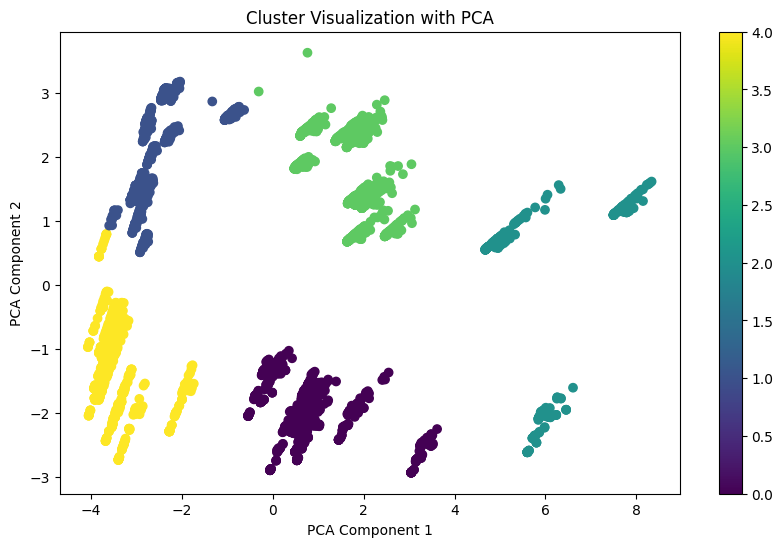

In [65]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Load your data into a DataFrame
data = final_wavelet_results_df  # Replace with your DataFrame variable

# Select relevant numeric columns
features = [
    'wavelet_mse', 'wavelet_energy_entropy', 'wavelet_sparsity',
    'dominant_frequency', 'dynamic_cutoff', 'num_peaks', 'peak_amplitude',
    'relative_num_peaks', 'avg_prominence', 'max_autocorrelation',
    'spectral_centroid', 'spectral_bandwidth', 'spectral_magnitude', 'total_pages', 'total_tokens', 'total_digits'
]

# Retain the original index during feature selection
clustering_data = data[features].dropna()  # Drop rows with missing values for clustering

# Normalize features
scaler = StandardScaler()
normalized_data = scaler.fit_transform(clustering_data)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust n_clusters as needed
clusters = kmeans.fit_predict(normalized_data)



# Perform PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_data)
# Add cluster labels back to the subset DataFrame
clustering_data['cluster'] = clusters
clustering_data['pca_1'] = pca_result[:, 0]
clustering_data['pca_2'] = pca_result[:, 1]
# Merge cluster labels back into the original DataFrame
data = data.merge(clustering_data[['cluster', 'pca_1', 'pca_2']], left_index=True, right_index=True, how='left')
# Visualize the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
plt.colorbar(scatter)
plt.title("Cluster Visualization with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [66]:
from sklearn.metrics import silhouette_score
score = silhouette_score(normalized_data, clusters)
console.print(f"Silhouette Score: {score}")

Silhouette Score: 0.42272751875153913

In [69]:
selection = alt.selection_point(bind='legend', fields=['htid'])
alt.Chart(data[data.combined_wavelet_rank < 11]).mark_point(filled=True, opacity=0.7).encode(
	x='pca_1',
	y='pca_2',
	color='total_pages:O',
	shape='wavelet:N',
	tooltip=['htid', 'combined_wavelet_rank', 'wavelet', 'wavelet_level', 'wavelet_mode', 'signal_type'] + features,
	opacity=alt.condition(selection, alt.value(1), alt.value(0.1)),
	row='signal_type:N',
	column='htid:N'
).add_params(selection).properties(
	title='Wavelet Clustering',
	width=100,
	height=100
)

alt.Chart(...)

In [56]:
alt.Chart(data[data.combined_wavelet_rank < 11]).mark_point(filled=True, opacity=0.7).encode(
	x='pca_1',
	y='pca_2',
	color='combined_wavelet_rank:O',
	shape='signal_type:O',
	tooltip=['htid', 'combined_wavelet_rank', 'wavelet', 'wavelet_level', 'wavelet_mode', 'signal_type'] + features,
	row='htid:N',
	column='wavelet:N'
).properties(
	title='Wavelet Clustering',
	width=200,
	height=100
)

alt.Chart(...)

In [57]:
rank_counts = data[data.combined_wavelet_rank < 11].groupby(['cluster', 'combined_wavelet_rank']).size().reset_index(name='rank_count').sort_values(by=['cluster', 'combined_wavelet_rank', 'rank_count'], ascending=[True, True, False])

# Select the top-ranked wavelet for each cluster

top_wavelets = data.loc[data.groupby('cluster')['combined_wavelet_rank'].idxmin()][['cluster', 'combined_wavelet_rank', 'htid', 'wavelet', 'wavelet_level', 'wavelet_mode', 'signal_type']]
console.print(top_wavelets)

console.print("Top Wavelets by Cluster", style="bright_green")
console.print(rank_counts)

cluster  combined_wavelet_rank                htid wavelet  \
2154        0                      1      uva.x004246277    haar   
396         1                      1  inu.32000001537499    haar   
132         2                      1  inu.30000108552971   coif5   
0           3                      1  inu.30000108552963   coif5   
1           4                      2  inu.30000108552963    haar   

      wavelet_level   wavelet_mode signal_type  
2154              1      symmetric    smoothed  
396               1      symmetric    smoothed  
132               1       constant         raw  
0                 2       constant         raw  
1                 7  periodization    smoothed

Top Wavelets by Cluster

cluster  combined_wavelet_rank  rank_count
0         0                      1           2
1         0                      2           2
2         0                      3           2
3         0                      4           2
4         0                      5           2
5         0                      6           1
6         0                      7           1
7         0                      8           1
8         0                      9           2
9         0                     10           1
10        1                      1           2
11        1                      2           2
12        1                      3           2
13        1                      4           8
14        1                      5          10
15        1                      6          11
16        1                      7           8
17        1                      8          10
18        1                      9          10
19        1                     10          10
20        2                      1          17
21        2                      2          15
22        2                      3          14
23        2                      4          13
24        2                      5          12
25        2                      6           4
26        2                      7           1
27        2                      8           1
28        2                      9           1
29        2                     10           1
30        3                      1           9
31        3                      2           8
32        3                      3           8
33        3                      4           2
34        3                      7           3
35        3                      8           1
36        3                     10           1
37        4                      2           3
38        4                      3           4
39        4                      4           5
40        4                      5           6
41        4                      6          14
42        4                      7          17
43        4                      8          17
44        4                      9          17
45        4                     10          17